In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))


## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture

## PCCA+ from pyemma
from pyemma.msm import PCCA

## import 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from torch.nn import init
import torch.optim as optim

## don't show warning
import warnings
warnings.filterwarnings('ignore')

# import the Escal Tools
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))
import basicTools as bt
import Etranform as et
from Etranform import Efft as et
from mapTools import encoder as mt
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
## the data directory
datadir = os.path.realpath("../../data")
fname = "350"
filePref = f"{datadir}/{fname}"
print("The analysis will do for: \n", filePref)

## The data per frames
skip = 1

### smooth
step    = 100
width   = 200
seg2vec = bt.segment.medoid

### similar metrix
similar = bt.dist.cosin

### evalute method
evalute = bt.evalute.cluster

The analysis will do for: 
 /home/ghzuo/data/gromacs/data.Chignolin/5awl/unfolding/350


# The Input Data

## Structure of Trajectory

In [3]:
## read data from file
dih = pd.DataFrame(np.loadtxt(f"{filePref}-rama.xvg", comments=["@","#"],
                             dtype = {'names': ('Phi', 'Psi', 'Residue'),
                                     'formats': ('f', 'f', 'S7')}))
print("The shape of input file is: ", dih.shape)
X0 = bt.feature.dih2X(dih)
X0 = X0.loc[1::skip,:].reset_index(drop=True)
X0 = np.array(X0)
print("The shape of X0 is: ", X0.shape)

The shape of input file is:  (800008, 3)
The shape of X0 is:  (100000, 32)


## Energy of Trajectory

In [4]:
## read the energy data
eng = pd.DataFrame(np.loadtxt(f"{filePref}-potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))

### base frequence in MHz
## 1000,000 for M and P, and 2 for even extension
ufreq = 500000/eng.loc[len(eng)-1, "time"]
print("The base frequence is {:.4f} MHz".format(ufreq))

E0 = np.array(eng.loc[1::skip, 'energy'])
print("The shape of Energy is: ", E0.shape)

The base frequence is 0.5000 MHz
The shape of Energy is:  (100000,)


## RMSD from Native Structure

In [5]:
rms = np.loadtxt(f"{filePref}-CaRMS.xvg", comments=["@","#"],
                 dtype = {'names': ('time', 'rms'), 
                          'formats': ('f', 'f')})
rms = rms[1::skip]
print("The shape of RMS is: ", rms.shape)

The shape of RMS is:  (100000,)


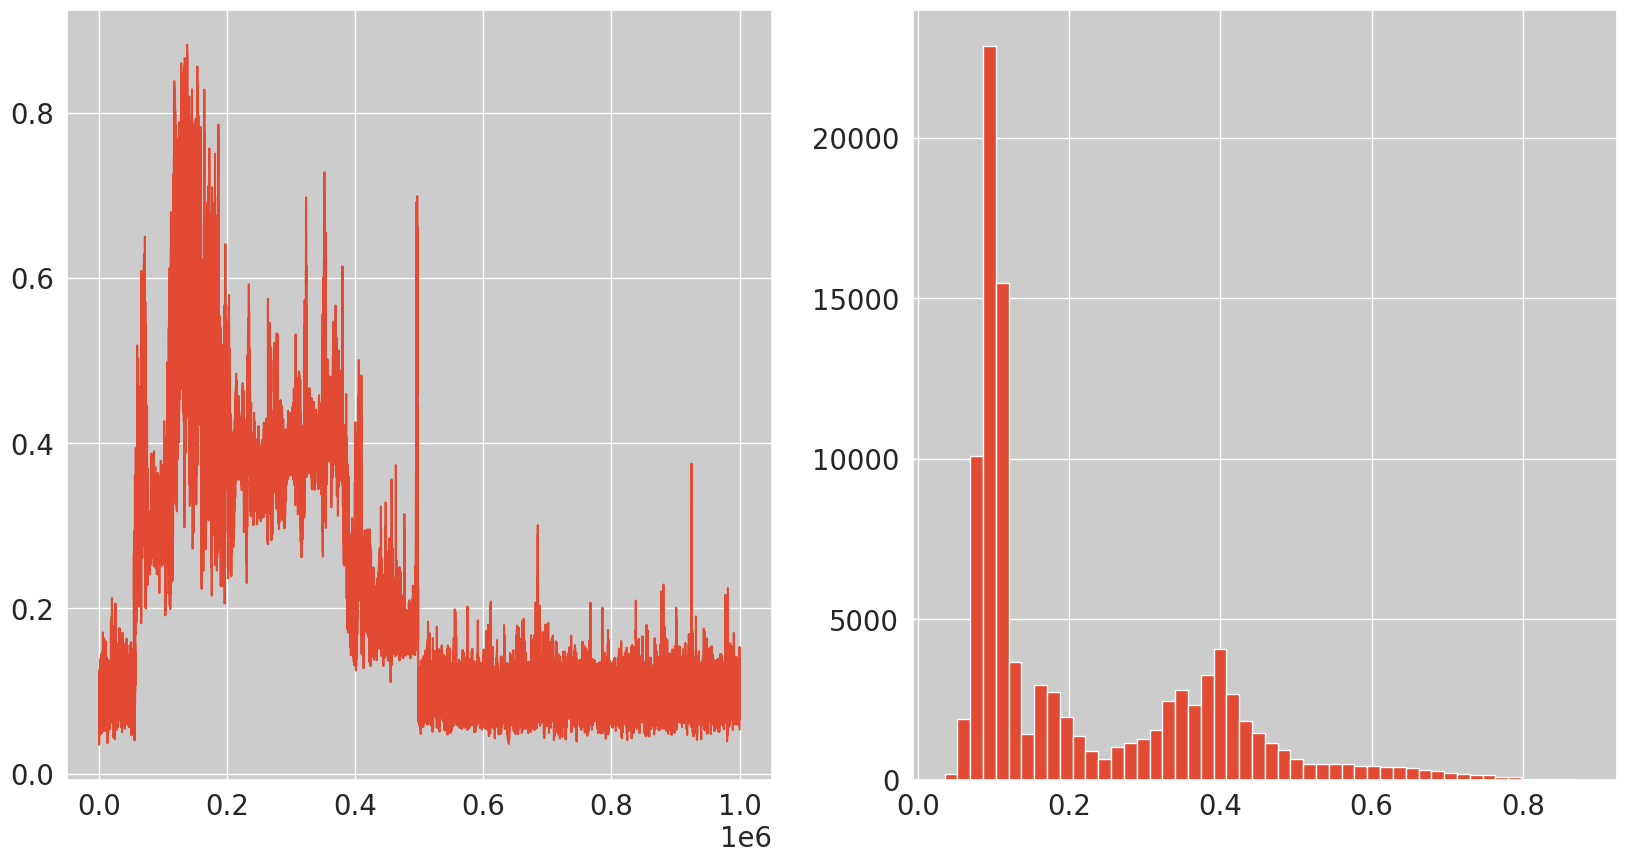

In [6]:
plt.figure(12,figsize=(20,10))
ax = plt.subplot(121)
ax.plot(rms['time'], rms['rms'])
ax = plt.subplot(122)
hist = ax.hist(rms["rms"], bins=50, )

# Data Rescaling

## Multiple Correlation Coefficient

In [7]:
## do FFT rescaling
efft = et(X0, E0, base = False)

In [8]:
num_inputs = X0.shape[1]
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('features', nn.Linear(num_inputs, 1))
        ]))
print(net, "\n") 

Sequential(
  (features): Linear(in_features=32, out_features=1, bias=True)
) 



In [9]:
## set mapping method
xmap = mt.EncoderNet(net, info=2)
xmap.preTrain(efft,n_epochs=20)

epoch 1, loss: 1106694.750000
epoch 2, loss: 910329.812500
epoch 3, loss: 253900.843750
epoch 4, loss: 220105.578125
epoch 5, loss: 47734.976562
epoch 6, loss: 18894.902344
epoch 7, loss: 115502.773438
epoch 8, loss: 11892.744141
epoch 9, loss: 2401.170654
epoch 10, loss: 995.699097
epoch 11, loss: 200.780182
epoch 12, loss: 182.755829
epoch 13, loss: 384.441101
epoch 14, loss: 171.107590
epoch 15, loss: 55.809242
epoch 16, loss: 46.359253
epoch 17, loss: 48.869068
epoch 18, loss: 29.305248
epoch 19, loss: 84.674103
epoch 20, loss: 55.369740
Validate for PreTrain (kappa=2): 0.7017618629447538 80.798583984375 41.007728576660156


In [10]:
## get the score
qmc = xmap.score(efft, n_epochs=5)

epoch 1, loss: 56.897758
epoch 2, loss: 17.214203
epoch 3, loss: 95.658783
epoch 4, loss: 19.130634
epoch 5, loss: 44.554943
Validate for Score (kappa=2.0): 0.7433125723291413 80.798583984375 36.15626907348633
epoch 1, loss: 10.041437
epoch 2, loss: 87.820877
epoch 3, loss: 96.132362
epoch 4, loss: 44.945637
epoch 5, loss: 48.458855
Validate for Score (kappa=3.0): 0.7195374820566477 81.9120864868164 39.50339889526367
epoch 1, loss: 46.359364
epoch 2, loss: 14.739215
epoch 3, loss: 8.226880
epoch 4, loss: 13.912603
epoch 5, loss: 33.684795
Validate for Score (kappa=4.0): 0.8194351547346082 103.62984466552734 34.045101165771484
epoch 1, loss: 14.073248
epoch 2, loss: 8.269549
epoch 3, loss: 4.424262
epoch 4, loss: 8.265406
epoch 5, loss: 13.313471
Validate for Score (kappa=5.0): 0.9073218639865466 120.16651153564453 21.241477966308594
epoch 1, loss: 18.696686
epoch 2, loss: 11.223645
epoch 3, loss: 32.900673
epoch 4, loss: 35.993439
epoch 5, loss: 23.639324
Validate for Score (kappa=6.0)

Text(19.7, 0.9109130995828455, '#15 (7.0 MHz)\nQMC = 0.93')

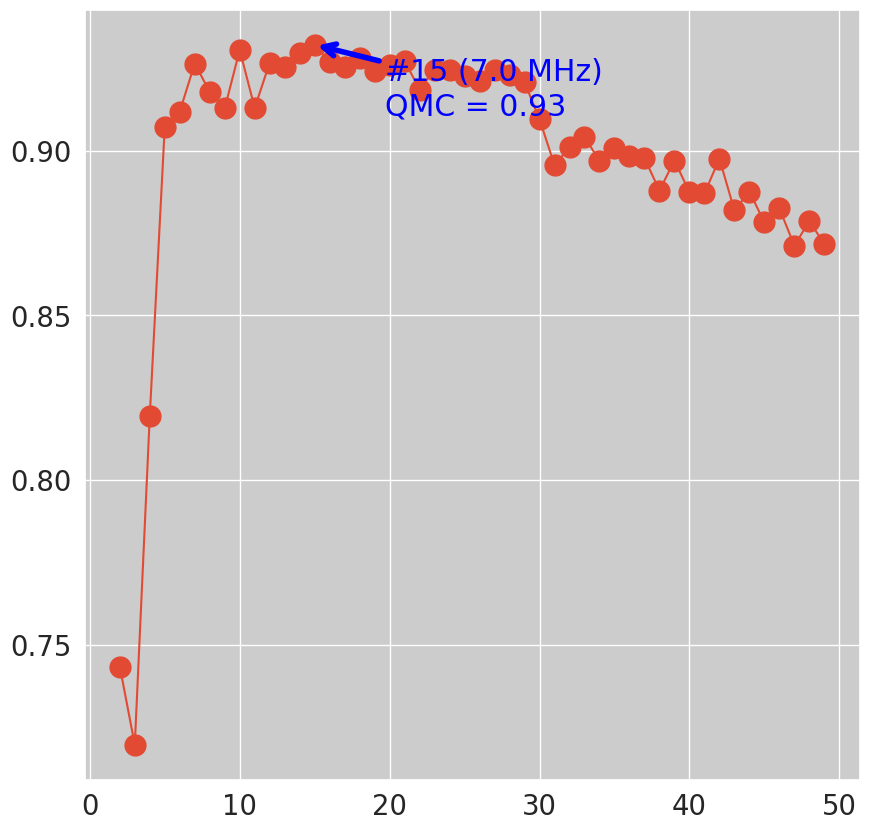

In [11]:
## plot the multiple correlation coefficient
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy     = (qmc['KappaMax'], qmc['qmcMax'])
offset = 0.1 * (np.max(qmc['list'], axis=0)-np.min(qmc['list'],axis=0))
xytxt  = [xy[0] + offset[0], xy[1] - offset[1]]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

## Weight of Features

In [12]:
rescl = xmap.scale(efft, qmc['KappaMax'])

epoch 1, loss: 19.872869
epoch 2, loss: 19.911860
epoch 3, loss: 17.136353
Validate for Scaling (kappa=15.0): 0.9315991780392451 162.21820068359375 21.432750701904297


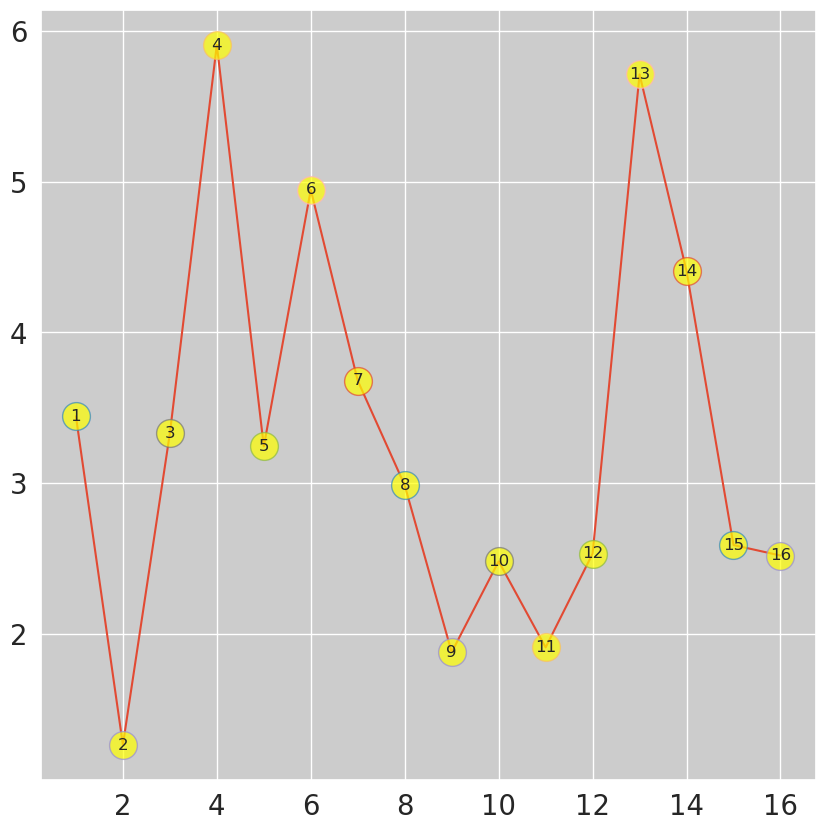

In [13]:
fscal = []
for i in range(0, len(rescl['A']), 2):
    fscal.append(np.sqrt(rescl['A'][i]*rescl['A'][i] 
                + rescl['A'][i+1]*rescl['A'][i+1]))
bt.plot.coefplot(fscal)

## Effective Energy

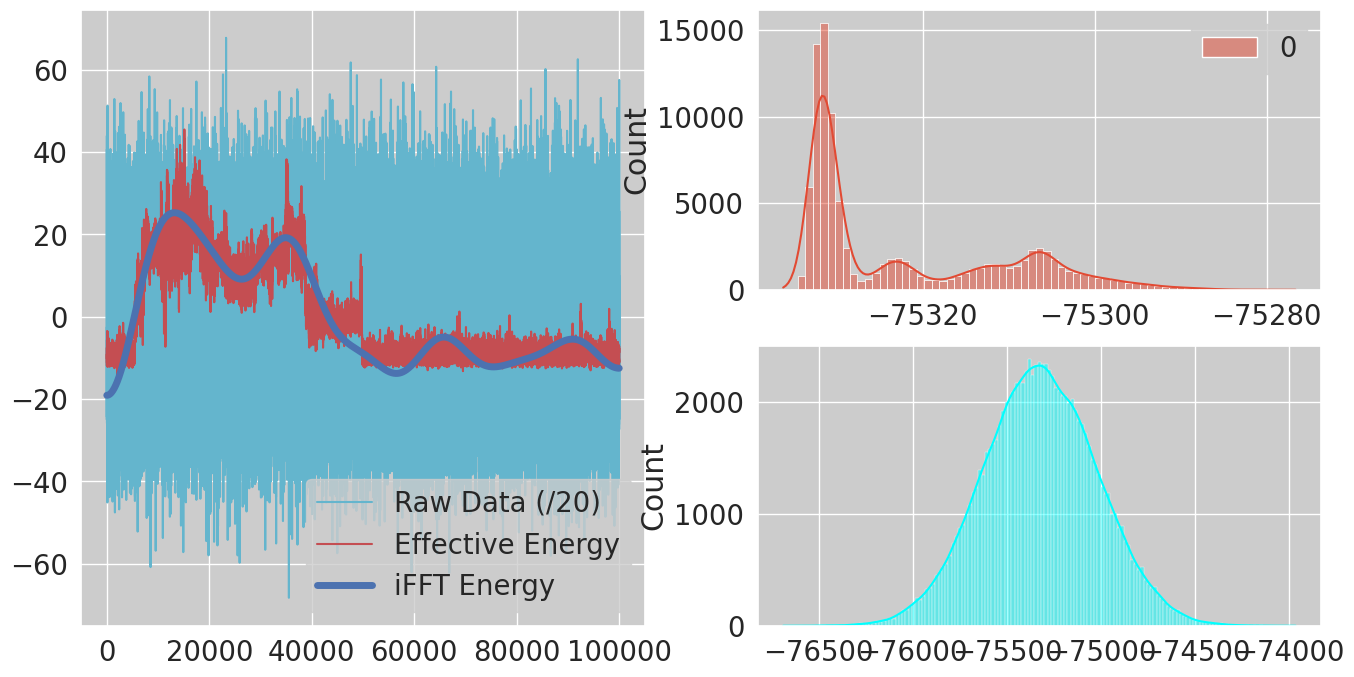

In [14]:
## plot the effective energy
bt.plot.efplot(E0, efft.Ef(qmc['KappaMax']), rescl['Ee'])

# Matrix Analysis

## Sample Data

In [15]:
## get the samples
X0s = seg2vec(X0, step, width)
Xys = seg2vec(rescl['X'], step, width)

## Testing Similarity Matrix

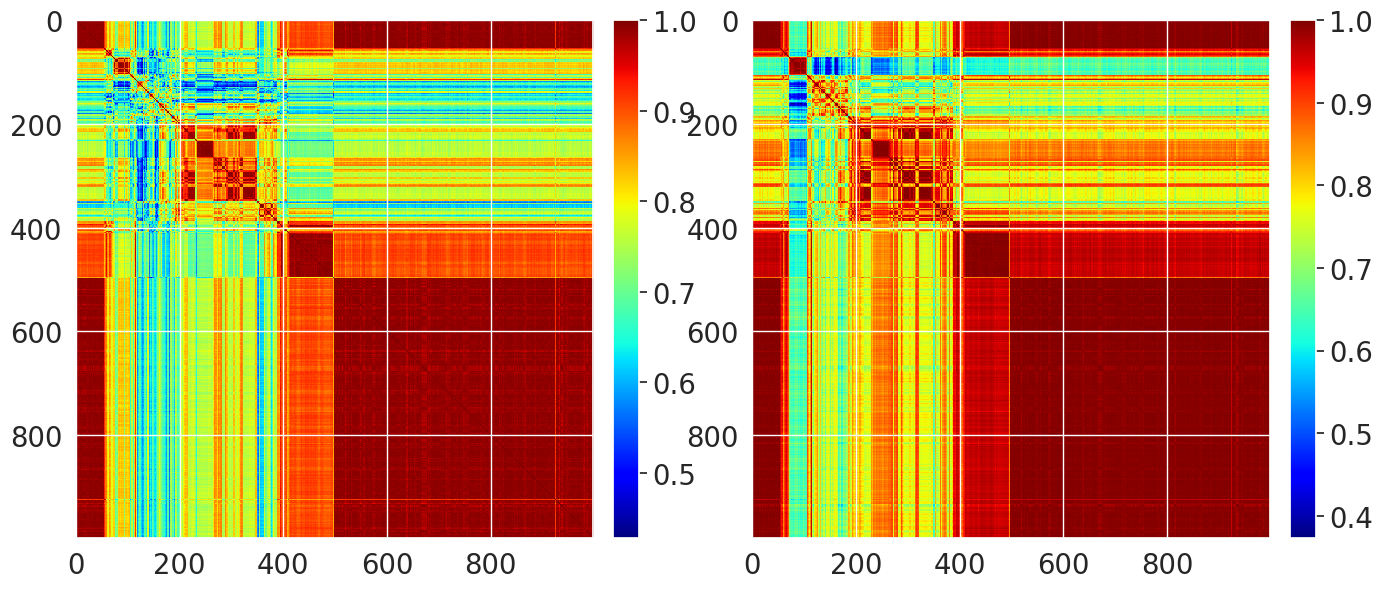

In [16]:
## set distance function and get distance
Smat0  = similar(X0s)
Smaty  = similar(Xys)
    
### plot
fig, axs = plt.subplots(1,2, figsize=(16,32)) 
bt.plot.implot(Smat0, axs[0])
bt.plot.implot(Smaty, axs[1])

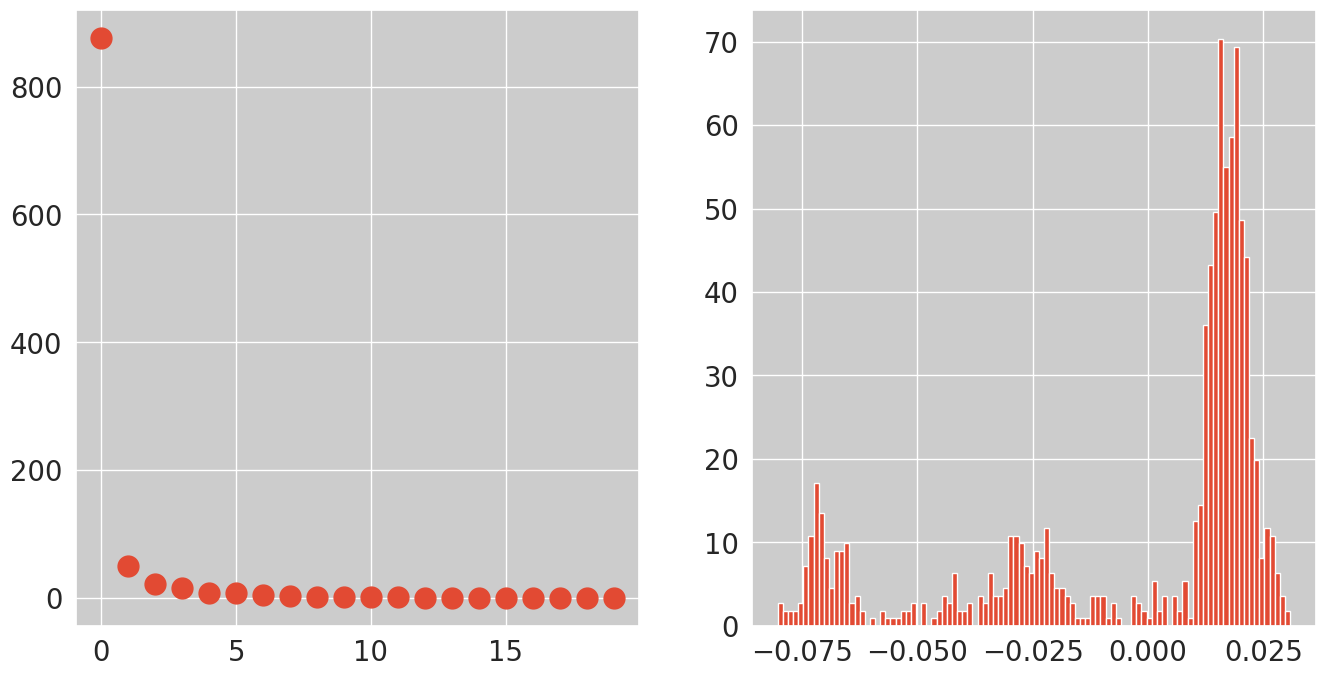

In [17]:
w,v = np.linalg.eig(Smaty)

fig, axs = plt.subplots(1,2, figsize=(16,8)) 
axs[0].plot(w[0:20], "o")
hist = axs[1].hist(v[:,1], bins=100, density=True)

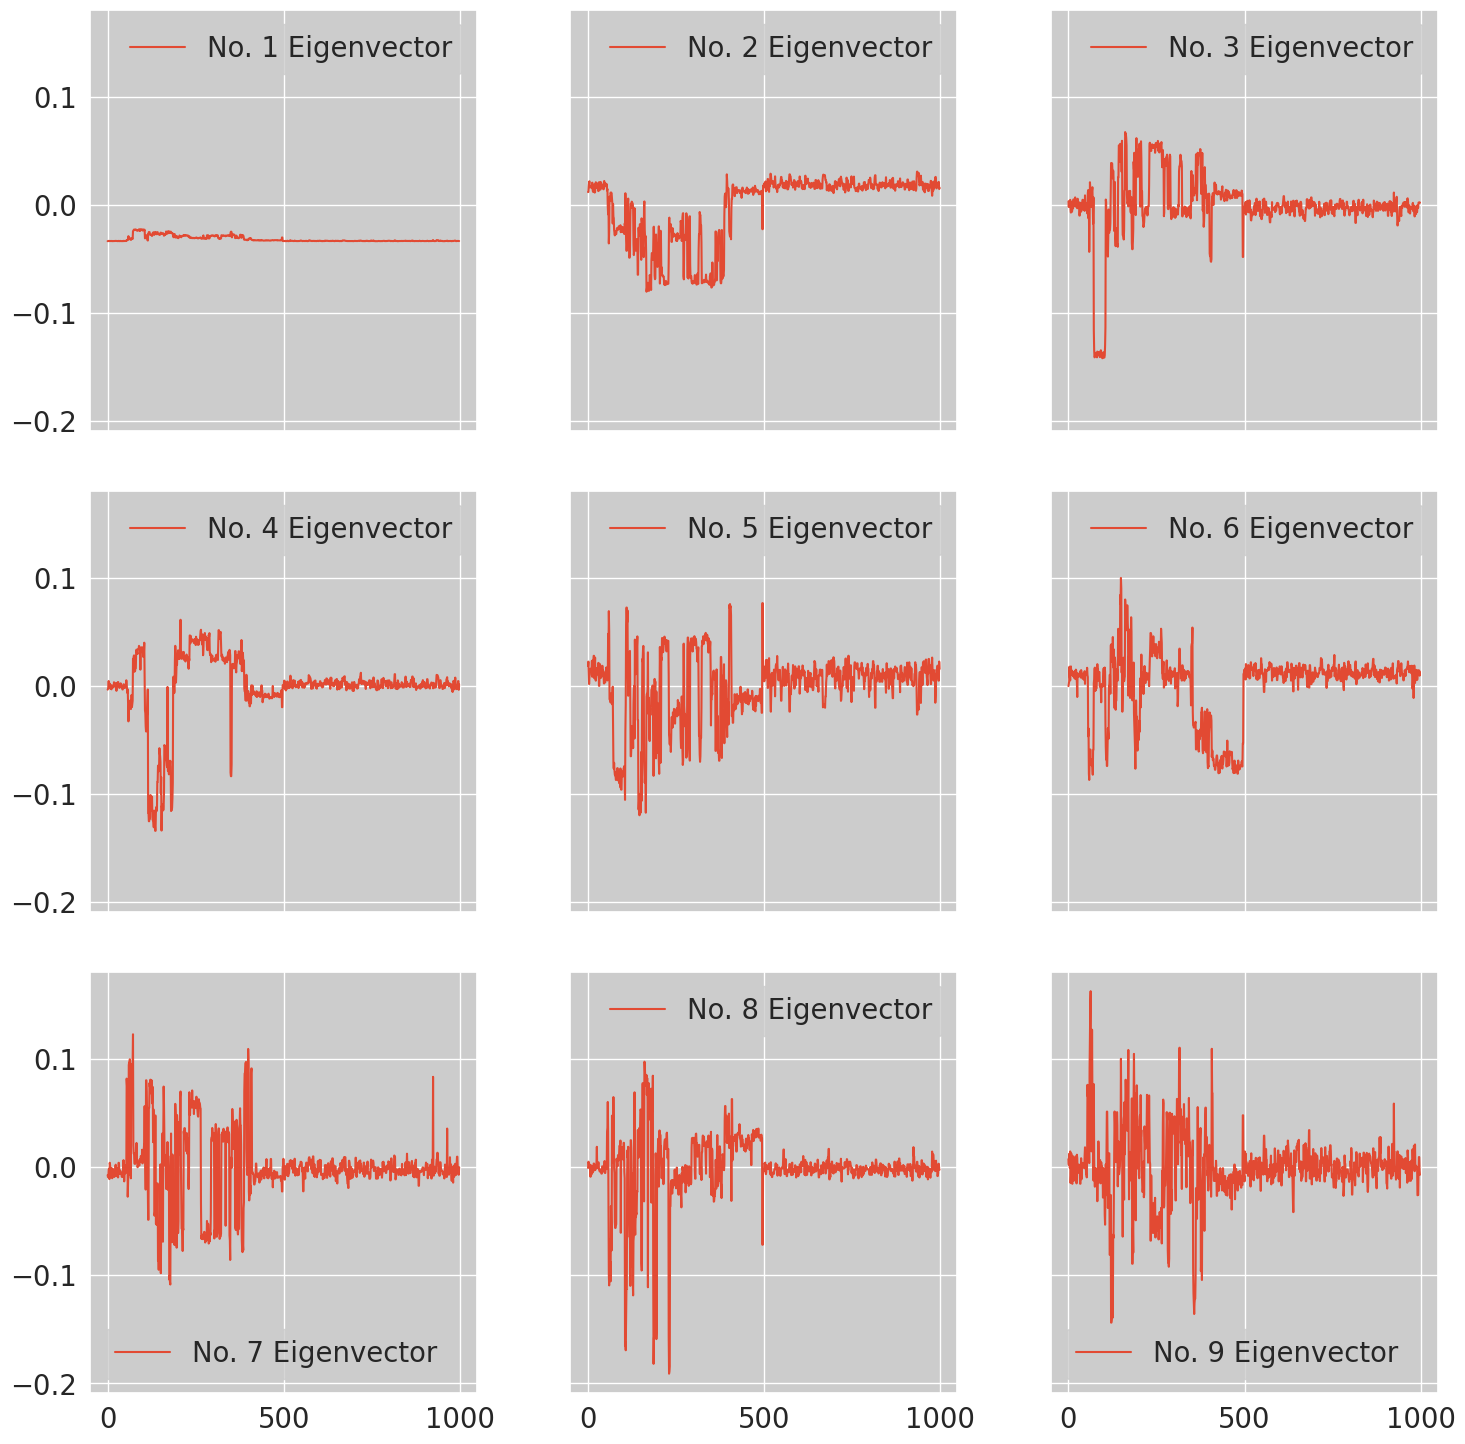

In [18]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

# Save Data

In [19]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [20]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = 'EscalNet-soloTraj.ipynb'
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"

!jupyter nbconvert --to pdf --no-input --log-level 40 \
    --output-dir {datadir} --output "EscalNet-"{fname}".pdf" \
    {srcfile}